In [ ]:
import uuid
from collections import OrderedDict
from pprint import pprint

import shap
import mlflow
from mlflow.tracking import MlflowClient

In [ ]:
#from statsmodels.graphics.mosaicplot import mosaic
#from scipy import interp

#import warning
#warnings.filterwarnings("ignore")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA

import xgboost as xgb
import lightgbm as lgb
#from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, log_loss, f1_score
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.metrics import roc_auc_score, auc, classification_report, balanced_accuracy_score, brier_score_loss
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve

from sklearn.datasets import load_breast_cancer

# `Init MLflow`

In [ ]:
mlflow_uri = 'http://127.0.0.1:5000/'
mlflow.set_tracking_uri(mlflow_uri)

# `Experiments`

### `Show all`

In [ ]:
client = MlflowClient()
expm_list = client.list_experiments() # returns a list of mlflow.entities.Experiment

for expm in expm_list:
    print(expm.to_proto())
    print('-'*50)

### `New Experiment`

In [ ]:
# Create an experiment name, which must be unique and case sensitive
expm_name = 'Classifier - Breast Model'

# Create OR get existing Experiment
try:
    expm_id = mlflow.create_experiment(expm_name)
except:
    expm_id = mlflow.get_experiment_by_name(expm_name).experiment_id

# get Experiment by ID
expm = mlflow.get_experiment(expm_id)

print(f"Name: {expm.name}")
print(f"Experiment_id: {expm.experiment_id}")
print(f"Artifact Location: {expm.artifact_location}")
print(f"Tags: {expm.tags}")
print(f"Lifecycle_stage: {expm.lifecycle_stage}")

In [ ]:
#mlflow.delete_experiment(expm_id)

### `Prepare dataset`

In [ ]:
### small - 569 samples
dataset = load_breast_cancer(return_X_y=False, as_frame=True)
X = dataset.data
y = dataset.target

### big - 32K samples
#X, y = shap.datasets.adult()

print(f'X shape: {X.shape}')
print(f'y - Class balance:\n{pd.Series(y).value_counts(normalize=True)}')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print()
print(f'y_train: {y_train.mean()}')
print(f'y_test: {y_test.mean()}')

#### `Model - baseline`

In [ ]:
def eval_metrics(y_true: np.array, y_pred: np.array, problem_type: str) -> 'metrics_dict: dict':
    
    metrics_dict = OrderedDict()
    
    if problem_type == 'regression':
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        metrics_dict['mae'] = mae
        metrics_dict['mse'] = mse
        metrics_dict['rmse'] = rmse
        metrics_dict['mape'] = mape
        metrics_dict['r2'] = r2
        
    elif problem_type == 'binary_classification':
        # create binary classes from probabilities
        target_class_thr = 0.5
        y_class = [1 if p >= target_class_thr else 0 for p in y_pred]
        
        # for normalized LogLoss
        y_naive = copy.deepcopy(y_pred) * 0 + y_true.mean()
        base_logloss = log_loss(y_true, y_naive)
        
        accuracy = accuracy_score(y_true, y_class)
        balanced_accuracy = balanced_accuracy_score(y_true, y_class)
        precision = precision_score(y_true, y_class)
        recall = recall_score(y_true, y_class)
        f1 = f1_score(y_true, y_class)
        logloss = log_loss(y_true, y_pred)
        norm_logloss = logloss / base_logloss
        brier_score = brier_score_loss(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)
    
        metrics_dict['accuracy'] = accuracy
        metrics_dict['balanced_accuracy'] = balanced_accuracy
        metrics_dict['f1'] = f1
        metrics_dict['precision'] = precision
        metrics_dict['recall'] = recall
        metrics_dict['logloss'] = logloss
        metrics_dict['norm_logloss'] = norm_logloss
        metrics_dict['brier_score'] = brier_score
        metrics_dict['roc_auc'] = roc_auc
        metrics_dict['pr_auc'] = pr_auc
        
    else:
        raise ValueError(f'Unknown problem_type: "{problem_type}"')
    
    return metrics_dict

In [ ]:
### Enable MLflow autologging for scikit-learn
### Models, parameters, and training metrics are tracked automatically
#mlflow.sklearn.autolog(log_input_examples=True)

### OR you can enable it for all supported libs
mlflow.autolog(log_input_examples=True)

In [ ]:
#model = RandomForestClassifier(n_estimators=1, max_depth=1, random_state=SEED)
#model = DecisionTreeClassifier(random_state=SEED)
model = xgb.XGBClassifier(random_state=SEED)

model_name = str(model).split('(')[0] # full model name
model_name = ''.join(c for c in model_name if c.isupper()) # short model name
model_id = uuid.uuid4().hex[:8]
run_name = f'{model_name}_{model_id}'
print(f'=== Run name: "{run_name}" ===')

# Run Experiment
with mlflow.start_run(experiment_id=expm_id, run_name=run_name) as run:
    
    ### train
    model.fit(X_train.iloc[:,:], y_train[:])

    ### save model
    model_schema = mlflow.models.infer_signature(X_test, model.predict_proba(X_test))
    model_info = mlflow.sklearn.log_model(model, 'model', registered_model_name='breast_model', signature=model_schema)
    
    # save output examples
    output_file = 'output_example.txt'
    np.savetxt(output_file, y_prob[:10, 1], fmt='%.18f')
    mlflow.log_artifact(output_file, 'model')
    
    ### predict & evaluate
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # custom metrics
    model_metrics = eval_metrics(y_test, y_prob[:,1], problem_type='binary_classification') 
    mlflow.log_metrics(model_metrics)
    ### OR you can log just 1 metric
    #mlflow.log_metric('test_roc_auc', metrics_dict['roc_auc']) 
        
    print(f'Classification report:\n{classification_report(y_test, y_pred)}')
    print(f'=== Metrics ===')
    pprint(metrics_dict)
    
    # auto-metrics
    eval_data = X_test.copy(deep=True)
    eval_data["label"] = y_test
    
    result = mlflow.evaluate(
        model=model_info.model_uri,
        data=eval_data,
        targets="label",
        model_type="classifier",
        dataset_name="breast",
        evaluators=["default"],
    )


In [ ]:
pprint(result.metrics)

#### `Display plots from artifacts`

In [ ]:
# for k,v in result.artifacts.items():
#     print(k)
#     display(v.content)

#### `Model - fine-tuned`

In [ ]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb
 
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': SEED, # Set a seed for deterministic training
}
 
def train_model(params):
    
    # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
    mlflow.xgboost.autolog()
    with mlflow.start_run(nested=True):
        # convert datasets
        train = xgb.DMatrix(data=X_train, label=y_train)
        validation = xgb.DMatrix(data=X_test, label=y_test)
        
        # train
        booster = xgb.train(params=params, dtrain=train, num_boost_round=20,\
                            evals=[(validation, "validation")], early_stopping_rounds=50)
        validation_predictions = booster.predict(validation)
        auc_score = roc_auc_score(y_test, validation_predictions)
        mlflow.log_metric('auc', auc_score)

        signature = mlflow.models.infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, "model", signature=signature)

        # Set the loss to -1*auc_score so fmin maximizes the auc_score
    
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}
 

trials = Trials()
 
# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
    best_params = fmin(
        fn=train_model, 
        space=search_space, 
        algo=tpe.suggest, 
        max_evals=10,
        trials=trials,
    )

https://docs.databricks.com/_static/notebooks/mlflow/mlflow-end-to-end-example.html

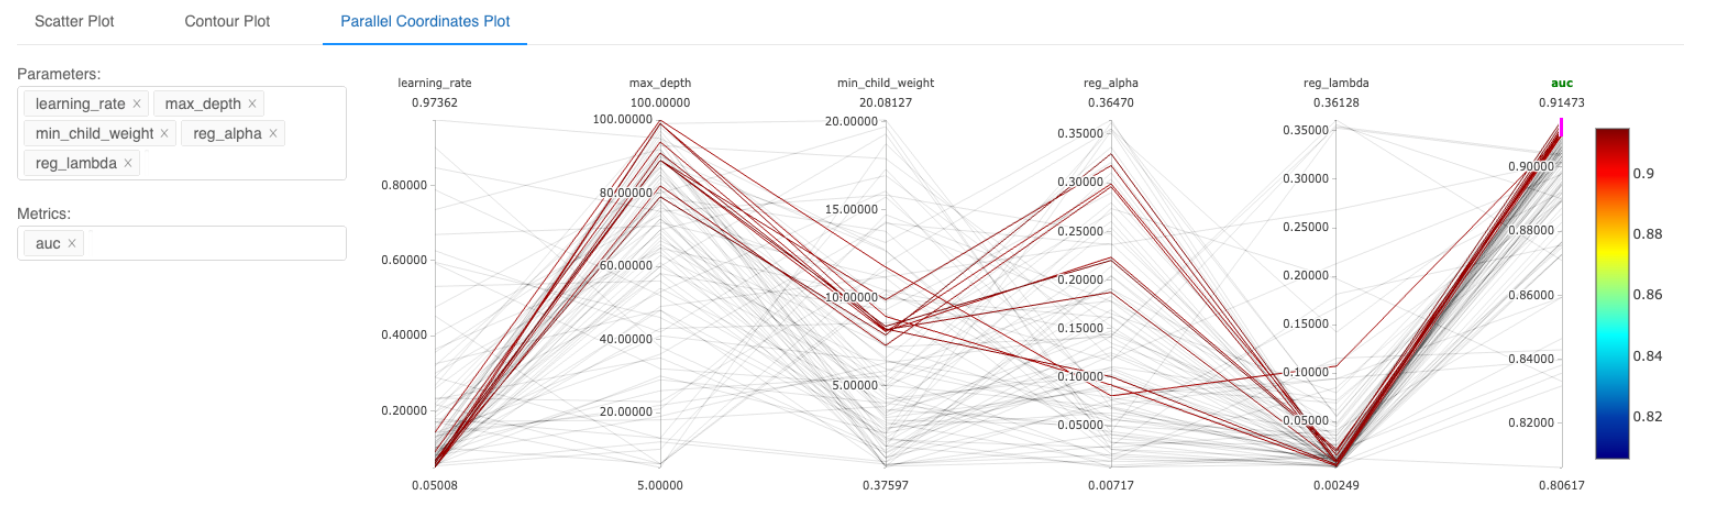

# `Logging example`

In [ ]:
feature_schema = {
    'numeric': [
        'i1',
        'i2',
    ],
    
    'categorical': [
        'c1',
        'c2',
    ],
}

In [ ]:
model_params = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": 1,
        "boosting_type": "gbdt",                
        "seed": SEED
    }

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot([0, 10]);

In [ ]:
with mlflow.start_run(run_name='Log example') as run:
    #mlflow.log_artifacts(os.getcwd())
    mlflow.log_artifact('mlflow_example.ipynb', 'code')
    mlflow.log_params(model_params)
    mlflow.log_dict(feature_schema, 'feature_schema.json')
    mlflow.log_dict(model_params, 'model_params.json')
    mlflow.log_dict(model_metrics, 'model_metrics.json')
    mlflow.log_text('Test text here!\nNext line!', 'text/log.txt')
    mlflow.log_figure(fig, 'bar_plot.png')

    #mlflow.sklearn.log_model(lr, "model")
    
run.info

# `Model Registry`

### `Register Model`

In [ ]:
run_id = 'e1019d727a1c47ccbe4ace4039e5341d'

result = mlflow.register_model(
    model_uri=f'runs:/{run_id}/model',
    name="sk-learn-random-forest-reg"
)

result

### `Transite Model`

In [ ]:
client = MlflowClient()

model_name = "autologged_model"

result = client.transition_model_version_stage(
  name=model_name,
  version=1,
  stage="Production",
)

result

### `Get model`

In [ ]:
model_name = "breast_model"
stage = 'Production'

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{stage}"
)

model

# `Model Serving`

### `Simple API`

In [ ]:
model_path = '/Users/mlflow/mlflow-prototype/mlruns/0/7c1a0d5c42844dcdb8f5191146925174/artifacts/model'

In [ ]:
! mlflow models serve -m {model_path} -p 1234

### `Test requests`

In [ ]:
import requests
import json

test_data = X_test.iloc[:10,:].to_dict(orient='split')

api_uri = f'http://127.0.0.1:1234/invocations'
response = requests.post(
              url=api_uri, data=json.dumps(test_data),
              headers={"Content-type": "application/json"})

response_json = json.loads(response.text)
print(response_json)

In [ ]:
y_pred[:10].tolist()